In [4]:
import torch
from model import pairScan
model = alleleScan(2,0.2)
sum(p.numel() for p in model.parameters())

422689

In [1]:
# General import, names of train, test, val
%load_ext autoreload
%autoreload 2
import numpy as np
import pysam
from tqdm.notebook import tqdm
import pandas as pd
import os
import datetime

basedir = '/data/leslie/shared/ASA/'
aligndir = f'{basedir}pseudodiploid/'
ctype = 'cd8'

datadir = f'{basedir}mouseASA/{ctype}/data/'
chrom_train = [1,2,4,6,7,8,9,11,12,13,14,16,17,18,19]
chrom_val = [3,5]
chrom_test = [10,15]
chroms = [chrom_train, chrom_val, chrom_test]
name = ['train', 'val', 'test']
seqlen = 300

# Plot test results

In [82]:
from run_back import load_data
modelname = 'm3'
dataset = 'trueref'
use_prior = '1'
batchsize = '32'
gc = ''
ident = '_vi_150bp'

# predspath = f'{basedir}mouseASA/{ctype}/preds/{modelname}_{dataset}_{use_prior}_{batchsize}{gc}{ident}.npy'
predspath = f'{basedir}mouseASA/{ctype}/preds/test_both_m3.npy'
print(predspath)
print(datetime.datetime.fromtimestamp(os.path.getmtime(predspath)))
y_pred = np.load(predspath)
_,_,_,_,_,y_test = load_data(ctype,dataset,gc+ident,get_rc=False,frac=0.)

true_fc = y_test[len(y_test)//2:] - y_test[:len(y_test)//2]
pred_fc = y_pred[len(y_pred)//2:] - y_pred[:len(y_pred)//2]

print(np.max(np.abs(true_fc)))
print(np.max(np.abs(pred_fc)))

/data/leslie/shared/ASA/mouseASA/data/cd8/preds/test_both_m3.npy
2023-06-14 09:07:51.259417
4.279732252295876
4.1250052


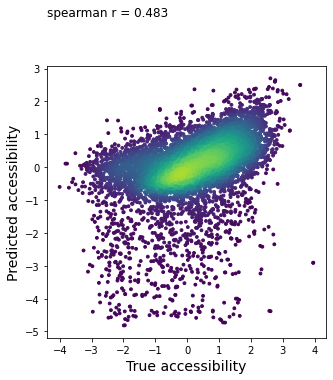

In [83]:
# Overall Spearman plot:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, spearmanr

x, y = y_test, y_pred
cor = spearmanr(x,y).correlation

xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

plt.figure(figsize=(5,5))
plt.scatter(x, y, c=z, s=8, vmax = 0.2)
plt.ylabel('Predicted accessibility', fontsize = 14)
plt.xlabel('True accessibility', fontsize = 14)
plt.text(-2.5, 4.5, 'spearman r = {:.3f}'.format(cor), 
         ha='center', va='bottom',fontsize=12)
plt.show()

/scratch/lsftmp/18385322.tmpdir/ipykernel_56256/1819361023.py:24: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  ax.scatter(totalcov , true_fc, c = 'lavender', cmap = 'bwr', s = 8, vmax=1, vmin=-1, alpha=0.3 )


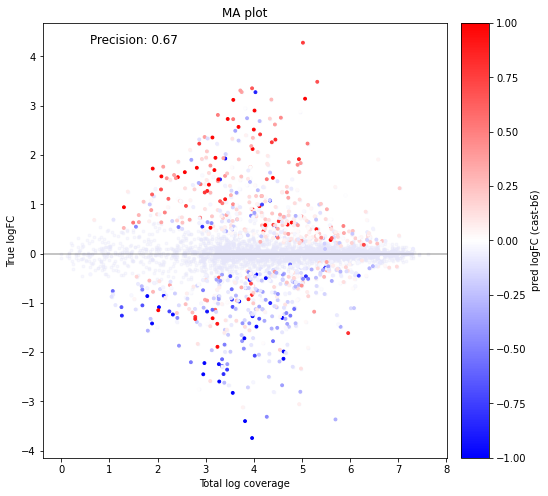

In [84]:
# MA plot
from mpl_toolkits.axes_grid1 import make_axes_locatable

def get_prec_rec(true_fc, pred_fc, sig_idx):
    temp = pred_fc[sig_idx]*true_fc[sig_idx]>0  # misclassifications are negative
    prec = np.sum(temp)/len(sig_idx)
    temp1 = pred_fc*true_fc>0
    rec = np.sum(temp)/np.sum(temp1)
    return prec, rec

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size="7%", pad=0.2,)

_,_,_,_,_,temp = load_data(ctype,dataset,'_noGC'+ident+'')        # load no GC dataset to get total log coverage
temp = temp[:len(temp)//2]
totalcov = np.log2(2**temp[:len(y_test)//2]+2**temp[len(y_test)//2:]-1)
# beta-binomial significance
betabin_pvals = pd.read_csv(datadir+'significance/betabinom_result_combCounts_150bp_testOnly.csv')['p.adj']
idx_sig = np.where(betabin_pvals<0.05)[0]

ax.axhline(0, c='k', alpha=0.3)
ax.scatter(totalcov , true_fc, c = 'lavender', cmap = 'bwr', s = 8, vmax=1, vmin=-1, alpha=0.3 )
a = ax.scatter(totalcov[idx_sig] , true_fc[idx_sig], c = pred_fc[idx_sig], cmap = 'bwr', s = 8, vmax=1, vmin=-1 )
cbar = plt.colorbar(a, cax=cax)
cbar.set_label('pred logFC (cast-b6)')
ax.set_xlabel('Total log coverage')
ax.set_ylabel('True logFC')
ax.set_title('MA plot')
prec, rec = get_prec_rec(true_fc, pred_fc, idx_sig)
ax.text(1.5, 4.2, f'Precision: {prec:.2f}',
         ha='center', va='bottom',fontsize=12)
plt.show()

/scratch/lsftmp/18385322.tmpdir/ipykernel_56256/3623401906.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  ax.scatter(y_pred[:len(y_pred)//2], y_pred[len(y_pred)//2:],


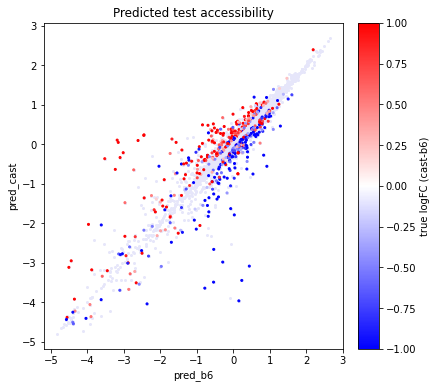

In [85]:
# Allele Specific predictions plot:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size="7%", pad=0.2,)

idx = np.where(np.abs(pred_fc)>0.1)[0]
idx = list(set(idx_sig).intersection(idx))

ax.scatter(y_pred[:len(y_pred)//2], y_pred[len(y_pred)//2:],
            vmax = 1, vmin = -1, cmap = 'bwr',s = 4,
           c = 'lavender')
a = ax.scatter(y_pred[:len(y_pred)//2][idx], y_pred[len(y_pred)//2:][idx],
            vmax = 1, vmin = -1, cmap = 'bwr',s = 4,
           c = true_fc[idx])
cbar = plt.colorbar(a, cax=cax)
cbar.set_label('true logFC (cast-b6)')
ax.set_title('Predicted test accessibility')
ax.set_xlabel('pred_b6')
ax.set_ylabel('pred_cast')
plt.show()

KstestResult(statistic=0.6301369863013698, pvalue=6.583731112065294e-14)


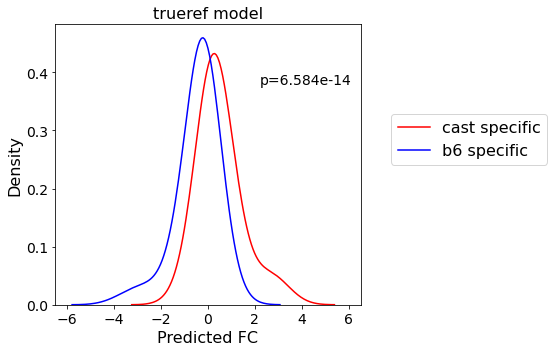

In [86]:
# KDE plot:
import seaborn as sns
from scipy.stats import ks_2samp

plt.rcParams['figure.figsize'] = 8, 5

# perform KS test on the peaks with foldchange in the top and bottom 2 percntile 
# pred_fc is the predicted foldchange and pred_fc_r is the predicted foldchange of the reverse complement
ks = ks_2samp(pred_fc[(true_fc)>np.percentile(true_fc, 98)],
              pred_fc[(true_fc)<np.percentile(true_fc, 2)])
print(ks)
sns.kdeplot(pred_fc[true_fc > np.percentile(true_fc, 98)], 
            color = 'red', bw = 0.7,legend = True,label="cast specific", linestyle="-")
sns.kdeplot(pred_fc[true_fc < np.percentile(true_fc, 2)], 
            color = 'blue', bw = 0.7,legend = True,label="b6 specific", linestyle="-")
plt.xlim(-6.5,6.5)
plt.xlabel('Predicted FC', fontsize = 16)
plt.ylabel('Density', fontsize = 16)
plt.title(dataset+' model', fontsize = 16)
plt.legend(fontsize = 16, loc = [1.1,0.5])
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.text(2.2,0.38,'p={0:.3e}'.format(ks.pvalue), fontsize = 14)
plt.tight_layout()

/scratch/lsftmp/18385322.tmpdir/ipykernel_56256/949613030.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(true_fc, pred_fc, vmax = 2, vmin = -2, s = 8, c = 'lavender')


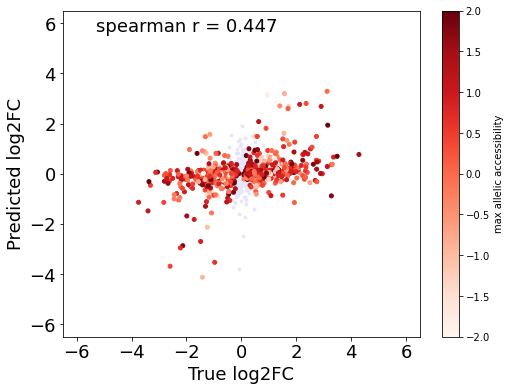

In [87]:
# Red spearman plot for fc
plt.rcParams['figure.figsize'] = 8, 6

# fc_cutoff = 0. # Cutoff for peak foldchange. Points with lower absolute fold-change are greyed out
# cor = spearmanr(true_fc[abs(true_fc)>fc_cutoff],pred_fc[abs(true_fc)>fc_cutoff]).correlation
cor = spearmanr(true_fc[idx_sig], pred_fc[idx_sig]).correlation

plt.scatter(true_fc, pred_fc, vmax = 2, vmin = -2, s = 8, c = 'lavender')
plt.scatter(
           true_fc[idx_sig],pred_fc[idx_sig],
            vmax = 2, vmin = -2, cmap = 'Reds',s = 16, 
    c = np.max(np.array([y_test[:len(y_test)//2], y_test[len(y_test)//2:]]), axis=0)[idx_sig]
)
plt.ylabel('Predicted log2FC', fontsize = 18)
plt.xlabel('True log2FC', fontsize = 18)
plt.text(-2, 5.5, 'spearman r = {:.3f}'.format(cor), 
         ha='center', va='bottom',fontsize=18)
cbar = plt.colorbar()
cbar.set_label('max allelic accessibility')
plt.xlim(-6.5,6.5)
plt.ylim(-6.5,6.5)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.title('')
plt.show()

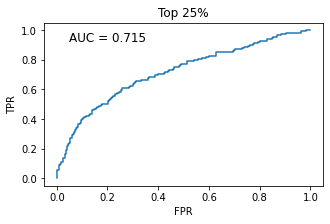

In [88]:
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
def plot_auc(x,y,name):
    if name=='roc':
        prc = roc_curve(x,y)
        plt.plot(prc[0],prc[1])
        plt.ylabel('TPR')
        plt.xlabel('FPR')
    elif name=='prc':
        prc = precision_recall_curve(x,y)
        plt.plot(prc[0],prc[1])
        plt.ylabel('Precision')
        plt.xlabel('Recall')
    plt.text(0.2, 0.9, 'AUC = {:.3f}'.format(roc_auc_score(x,y)), ha='center', va='bottom',fontsize=12)
    return

plt.figure(figsize=(5,3))

sig_cutoff = 0.05
p = 25
sig_true_fc = true_fc[betabin_pvals<sig_cutoff]
sig_pred_fc = pred_fc[betabin_pvals<sig_cutoff]
plot_auc((sig_true_fc > np.percentile(sig_true_fc,100 - p))*1,
         sig_pred_fc, 'roc')
plt.title('Top 25%')
plt.show()

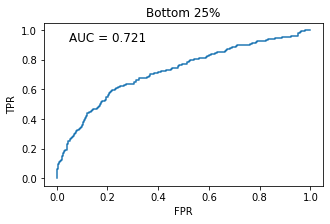

In [89]:
plt.figure(figsize=(5,3))
plot_auc((sig_true_fc < np.percentile(sig_true_fc,p))*1,
         -1*sig_pred_fc, 'roc')
plt.title('Bottom 25%')
plt.show()

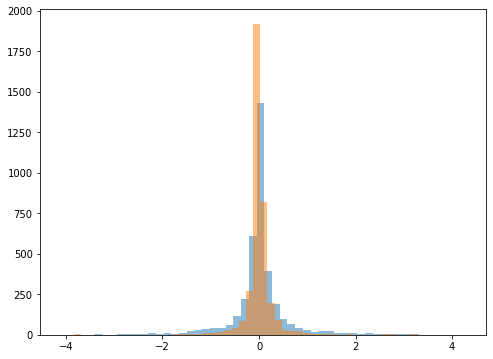

In [90]:
import matplotlib.pyplot as plt
# distribution of true and predicted log FC
plt.hist(true_fc, bins=50, alpha=0.5)
plt.hist(pred_fc, bins=50, alpha=0.5)
plt.show()

# Feature Attribution

In [91]:
from utils import unhot
flag = True    # True for specific peak, False for entire test set

if ident[:3]=='_vi':
    summits = pd.read_csv(aligndir+'cd8_old/yi_cd8_peaks_33143.csv',sep=',',index_col=0)
    summits['start'] += 150
    summits = summits.iloc[:,1:3]
    summits.columns = range(2)
else:
    summits = pd.read_csv(f'{datadir}/summits{ident}.csv', header=None)
print(len(summits))

33143


In [95]:
import torch
from run_back import load_data
from model import alleleScan
from captum.attr import IntegratedGradients
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

dataset = 'trueref'
use_prior = '1'
model = alleleScan(2, 0.2)
model.to(DEVICE)
# SAVEPATH = f'{basedir}mouseASA/{ctype}/ckpt_models/{ctype}_{modelname}_{dataset}_{use_prior}_{batchsize}{gc}{ident}.hdf5'
SAVEPATH = f'{basedir}mouseASA/{ctype}/ckpt_models/test_both_m3.hdf5'
print(SAVEPATH)
model.load_state_dict(torch.load(SAVEPATH))
model.eval()

method_name = 'IG'
ig = IntegratedGradients(model)

if flag:
    # code in case the locus is out of test set
    # finding a particular summit 12:4065636-4065785
    seq_name = '3:55488546'.split(':')
    c = int(seq_name[0])
    lims = [int(k) for k in seq_name[1].split('-')]
    print(c, lims)
    if len(lims)>1: # left and right limits given
        temp = summits.iloc[np.where(summits[0]==c)[0],:]
        temp = temp.iloc[list(set(np.where(temp[1]>lims[0])[0]).intersection(set(np.where(temp[1]<lims[1])[0])) )[0], 1]
    else:           # summit location given
        temp = lims[0]
    # find dataset with chromosome c
    i = [i for i in range(len(chroms)) if c in chroms[i]][0]
    print(f'found in {name[i]}..')
    x,y = [item for j,item in enumerate(load_data(ctype,'both',gc+ident,get_rc=False,frac=0.)) if (j==i or j==i+3)]

    # accumulate peak numbers in order to get index in x of particular summit
    idx = 0
    for chrom in chroms[i]:
        if chrom != c:
            idx += len(np.where(summits[0]==chrom)[0])
        else:
            chromsummits = summits.iloc[np.where(summits[0]==chrom)[0],:]
            idx += np.where(chromsummits[1]==temp)[0][0]
            break

    x = x[[idx,idx+len(x)//2]]
    y = y[[idx,idx+len(y)//2]]
    x_dna = unhot(x)

else:  # for test set
    _,_,x,_,_,y = load_data(ctype,'both',gc+ident,get_rc=False,frac=0.)
    x_dna = unhot(x)

    chromsummits = []
    for i in chrom_test:
        chromsummits.append(np.array(summits.loc[np.where(summits[0]==i)[0],1]))
    chromsummits = np.concatenate(chromsummits)

# x: one-hot encoded 300bp sequence inputs with shape (n, 300, 4)
attr = []

for i in tqdm( range(0, len(x), int(batchsize)) ):
    test_input_tensor = torch.from_numpy(x[i:i+int(batchsize)]).type(torch.FloatTensor).transpose(1,2).to(DEVICE)
    test_input_tensor.requires_grad_()
    attr.append(ig.attribute(test_input_tensor).detach().cpu().numpy())

attr = np.concatenate(attr)

/data/leslie/shared/ASA/mouseASA/ckpt_models/cd8/test_both_m3.hdf5
3 [55488546]
found in val..


  0%|          | 0/1 [00:00<?, ?it/s]

In [96]:
if not flag:
    # load modfile for SNP and indel locations
    import gzip

    def get_loci(mods, c, summit):
        mod_c = [x for x in mods if '\t'+str(c)+'\t' in x]
        mod_c = pd.DataFrame([x.split('\t') for x in mod_c])
        mod_c[2] = mod_c[2].astype(int)
        temp = mod_c.iloc[np.where(np.logical_and(mod_c[2]>=summit-150, mod_c[2]<=summit+150))[0], :]
        # insert clever code to deal with dels
        loci = list(temp[2]-(summit-150)+1)
        return loci

    modfile = aligndir+'gen/cast.mod'
    with gzip.open(modfile,'rt') as f:
        mods = f.read().split('\n')
        mods = [x for x in mods if not x.startswith('#')][:-1]            # filter out header lines
        mods = [x for x in mods for c in chrom_test if '\t'+str(c)+'\t' in x]   # filter to only the chromosomes of interest
    
    # Get sorted fc for ranking of differentially accessible peaks
    # Use shortlist of significant peaks only
    temp = np.sort( np.abs(true_fc[idx_sig]) )[::-1]

chr3: 55488396-55488696
True Log2fc (cast/b6): 3.5820564965851895
b6       IG


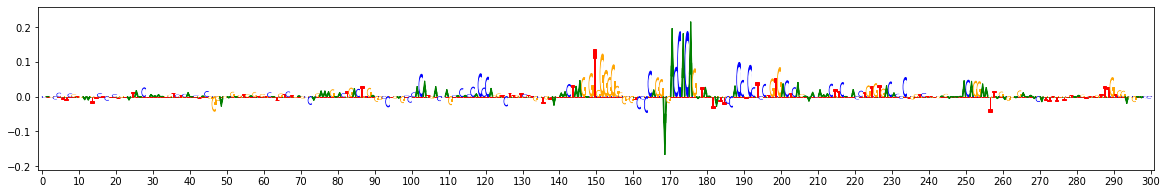

cast     IG


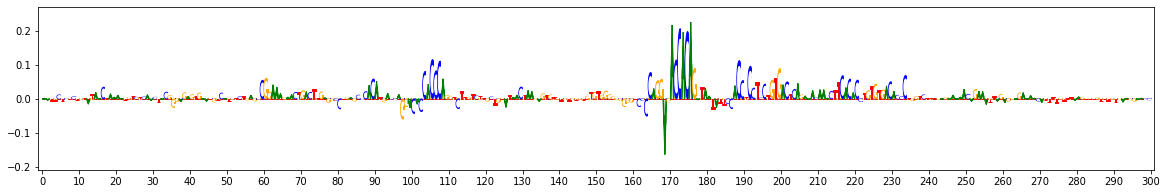

In [98]:
import deeplift
from deeplift.visualization import viz_sequence

if flag:
    i=0
    print(f'chr{c}: {temp-seqlen//2}-{temp+seqlen//2}')
    print('True Log2fc (cast/b6):', y[1]-y[0])
    # snp_idx, to be replaced with code to find SNP locations
#     idx = [58, 87, 91, 103, 114, 188, 192, 195, 202, 243, 254, 257, 264]
    idx=None
else:
    rank = 1       # fold change rank of true accessibility change
    i = np.where(np.abs(true_fc)==temp[rank-1])[0][0]
    if i>=len( np.array(summits.loc[np.where(summits[0]==chrom_test[0])[0],1]) ):
        c = chrom_test[1]
    else:
        c = chrom_test[0]
    
    # get locations of SNPs and indels
    idx = get_loci(mods, c, chromsummits[i])

    print(f'chr{c}: {chromsummits[i]-seqlen//2}-{chromsummits[i]+seqlen//2}')
    print('SNP/Indel location:', idx)
    print('True Log2fc (cast/b6):', true_fc[i])

seq_b6 = x_dna[i]
seq_ca = x_dna[len(x_dna)//2+i]


method_name = 'IG'

ylims = [-0.6,0.9]
scores_b6 = x[i]*attr[i].T
scores_ca = x[i+len(x)//2]*attr[i+len(x)//2].T
print('b6      ', method_name)
viz_sequence.plot_weights(scores_b6, subticks_frequency=10, figsize = (20,3), snp_list=idx) #, ylims=ylims)
print('cast    ', method_name)
viz_sequence.plot_weights(scores_ca, subticks_frequency=10, figsize = (20,3), snp_list=idx) #, ylims=ylims)

In [80]:
seq_b6

'TAAGGAGAATTTATTTCCTCAGACTCTTTCTGGAGTCCACCCTGTAGCCTGGAGTCATAGCTCTACCCTGCAACAGTAGGAAGCCACACCCTTCCAGGTCTTGCAGACACCACCACCACAAGGACCATGACAACCATCACCATAACAACCACCACACTTTTTTTTTTAAAGATAGTATCTCATTGGGGATAGTGGTTCACACCTTTAATCCCAGCACTCTGAAGGCAGAGGCAGACAGATCTGTCTCTGTGAGATCAAGGAGAGCCTGGTCTACAGCTCAAGTTCTAGGGCAGCCAAGGC'

In [18]:
seq_ca

'TAAGGAGAATTTATTTCCTCAGACTCTTTCTGGAGTCCACCCTGTAGCCTGGAGTCACAGCTCTACCCTGCAACAGTAGGAAGCCATACCGTTCCAGGTCTTACAGACACCACTACCACAAGGACCATGACAACCATCACCATAACAACCACCACACTTTTTTTTTTAAAGATAGTATCTCATTGGGCATAATGATTCACATCTTTAATCCCAGCACTCTGAAGGCAGAGGCAGACAGATCTATCTCTGTGAGTTCGAGGAGATCCTGGTCTACAGCTCAAGTTCTAGGGCAGCCAAGGC'

In [19]:
idx1=195
idx2=204
print(seq_b6[idx1-1:idx2])
print(seq_ca[idx1-1:idx2])

GTTCACACCT
ATTCACATCT
